In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# physio_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Physio/periods/features_segm_1.csv"
# driving_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"
# pvt_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [36]:
driving_path = "../Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(driving_path)

print(data.shape)

(58, 15)


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             58 non-null     int64  
 1   label_sleep            58 non-null     int64  
 2   label_first_scenario   58 non-null     object 
 3   label_time_exp         58 non-null     int64  
 4   period                 58 non-null     object 
 5   TO_Decision_Rural      58 non-null     int64  
 6   TO_RT_Rural            58 non-null     float64
 7   TO_MaxSWA_Rural        58 non-null     float64
 8   TO_ReengageTime_Rural  40 non-null     float64
 9   TO_MaxBraking_Rural    58 non-null     float64
 10  TO_Decision_Urban      49 non-null     float64
 11  TO_RT_Urban            49 non-null     float64
 12  TO_MaxSWA_Urban        49 non-null     float64
 13  TO_ReengageTime_Urban  39 non-null     float64
 14  TO_MaxBraking_Urban    49 non-null     float64
dtypes: float

In [39]:
data.head()

,subject_id,label_sleep,label_first_scenario,label_time_exp,period,TO_Decision_Rural,TO_RT_Rural,TO_MaxSWA_Rural,TO_ReengageTime_Rural,TO_MaxBraking_Rural,TO_Decision_Urban,TO_RT_Urban,TO_MaxSWA_Urban,TO_ReengageTime_Urban,TO_MaxBraking_Urban
0,1,0,Countryside,16,Country,1,2.450,5.0,12.399,100.0,1.0,1.484,1.0,9.900,100.0
1,2,1,Urban,16,Country,4,2.900,2.0,3.233,0.0,NaN,NaN,NaN,NaN,NaN
2,3,0,Countryside,16,Country,1,2.233,7.0,25.767,100.0,1.0,2.918,5.0,14.068,95.2
3,4,1,Countryside,16,Country,4,1.665,37.0,NaN,100.0,1.0,1.467,10.0,NaN,100.0
4,5,0,Countryside,10,Country,1,1.467,6.0,3.750,100.0,NaN,NaN,NaN,NaN,NaN


In [40]:
label_counts = data["label_sleep"].value_counts()
print(label_counts)

label_sleep
1    31
0    27
Name: count, dtype: int64


C:\Users\kahch\AppData\Local\Temp\ipykernel_162512\3141730654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


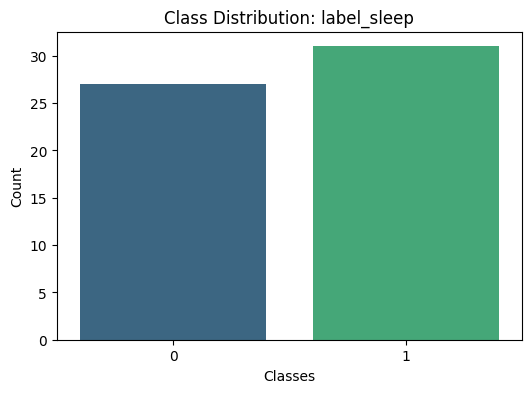

In [41]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Class Distribution: label_sleep")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


#Data Preprocessing

In [ ]:
columns_to_exclude = data.columns[data.isnull().mean() > 0.5]
data = data.drop(columns=columns_to_exclude)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_data = data.select_dtypes(include=['number'])

missing_values = numerical_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

data.fillna(numerical_data.mean(), inplace=True)

missing_after = data.isnull().sum()
print("\nMissing Values After Filling:\n", missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\nAll missing values have been successfully filled!")
else:
    print("\nThere are still missing values in the dataset.")

Missing Values:
 TO_ReengageTime_Rural    18
TO_Decision_Urban         9
TO_RT_Urban               9
TO_MaxSWA_Urban           9
TO_ReengageTime_Urban    19
TO_MaxBraking_Urban       9
dtype: int64

Missing Values After Filling:
 Series([], dtype: int64)

All missing values have been successfully filled!


In [43]:
data["label_first_scenario"] = data["label_first_scenario"].map({"Countryside": 0, "Urban": 1})
data["period"] = data["period"].map({"Country": 0, "Urban": 1})

print("\n'label_first_scenario' Column After Encoding:\n", data["label_first_scenario"].head())
print("\n'period' Column After Encoding:\n", data["period"].head())


'label_first_scenario' Column After Encoding:
 0    0
1    1
2    0
3    0
4    0
Name: label_first_scenario, dtype: int64

'period' Column After Encoding:
 0    0
1    0
2    0
3    0
4    0
Name: period, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label_sleep"] = label_encoder.fit_transform(data["label_sleep"])

print("Encoded Labels:\n", data["label_sleep"].unique())

Encoded Labels:
 [0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X = data.drop(columns=['subject_id', 'label_sleep']).values
y = data['label_sleep'].values

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {x_train.shape}")
print(f"Testing Set Size: {x_test.shape}")

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

Training Set Size: (46, 13)
Testing Set Size: (12, 13)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

x_train_rnn = x_train_norm.reshape(x_train_norm.shape[0], x_train_norm.shape[1], 1)
x_test_rnn = x_test_norm.reshape(x_test_norm.shape[0], x_test_norm.shape[1], 1)

input_size = x_train_norm.shape[1]
output_size = y_train.shape[1]

model = models.Sequential([
    layers.SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(x_train_rnn.shape[1], 1)),
    layers.Dropout(0.3),

    layers.SimpleRNN(32, activation='tanh', return_sequences=False),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),

    layers.Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    x_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_rnn, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

val_loss, val_accuracy = model.evaluate(x_test_rnn, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred = model.predict(x_test_rnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.4688 - loss: 1.1858 - val_accuracy: 0.7500 - val_loss: 1.0843
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5041 - loss: 1.1160 - val_accuracy: 0.6667 - val_loss: 1.0801
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5000 - loss: 1.1306 - val_accuracy: 0.6667 - val_loss: 1.0745
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5145 - loss: 1.1215 - val_accuracy: 0.6667 - val_loss: 1.0692
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5539 - loss: 1.1163 - val_accuracy: 0.5833 - val_loss: 1.0661
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4149 - loss: 1.1553 - val_accuracy: 0.5833 - val_loss: 1.0617
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6101 - loss: 1.0945 - val_accuracy: 0.6667 - val_loss: 1.0543
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7346 - loss: 1.0274 - val_accuracy: 0.7500 - val_loss

In [47]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

accuracy = accuracy_score(y_true_classes, y_pred_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.56      0.83      0.67         6

    accuracy                           0.58        12
   macro avg       0.61      0.58      0.56        12
weighted avg       0.61      0.58      0.56        12

Accuracy: 0.58
ROC-AUC Score: 0.86
Precision: 0.61
Recall: 0.58
F1-Score: 0.56


<Figure size 1000x800 with 0 Axes>

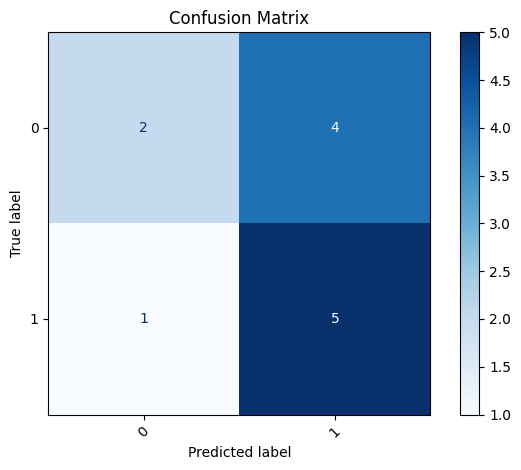

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

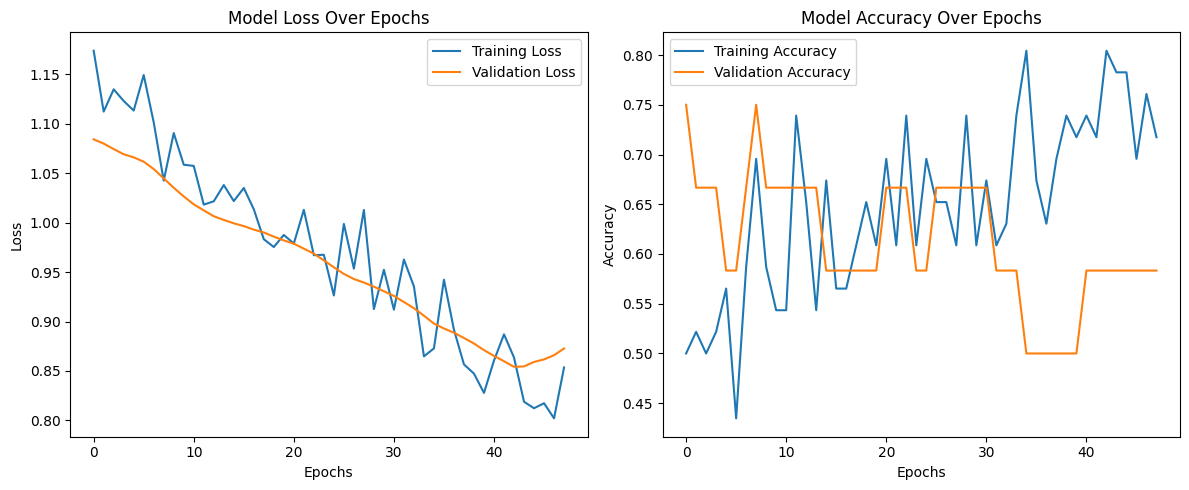

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

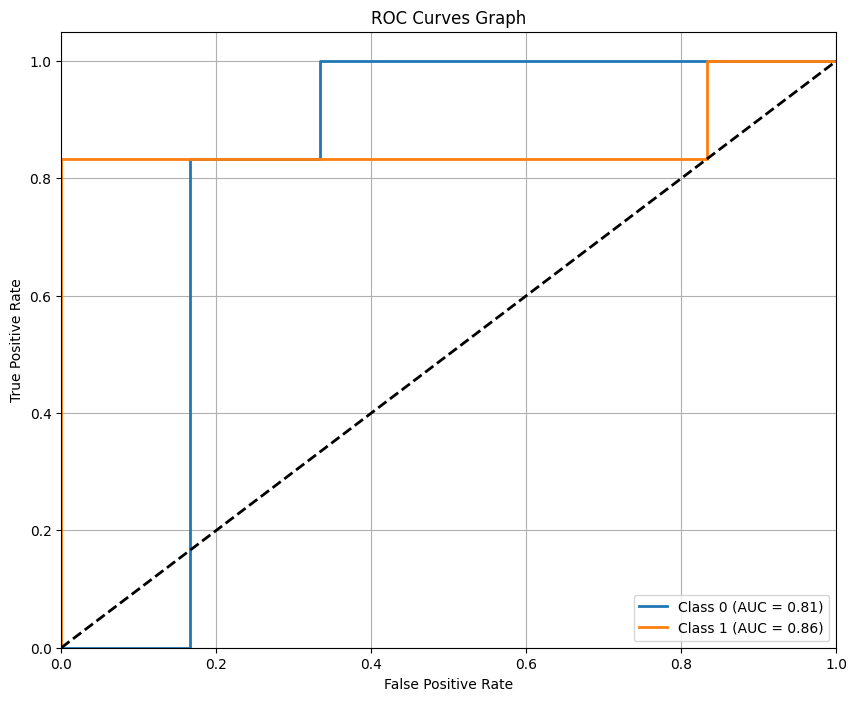

In [50]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

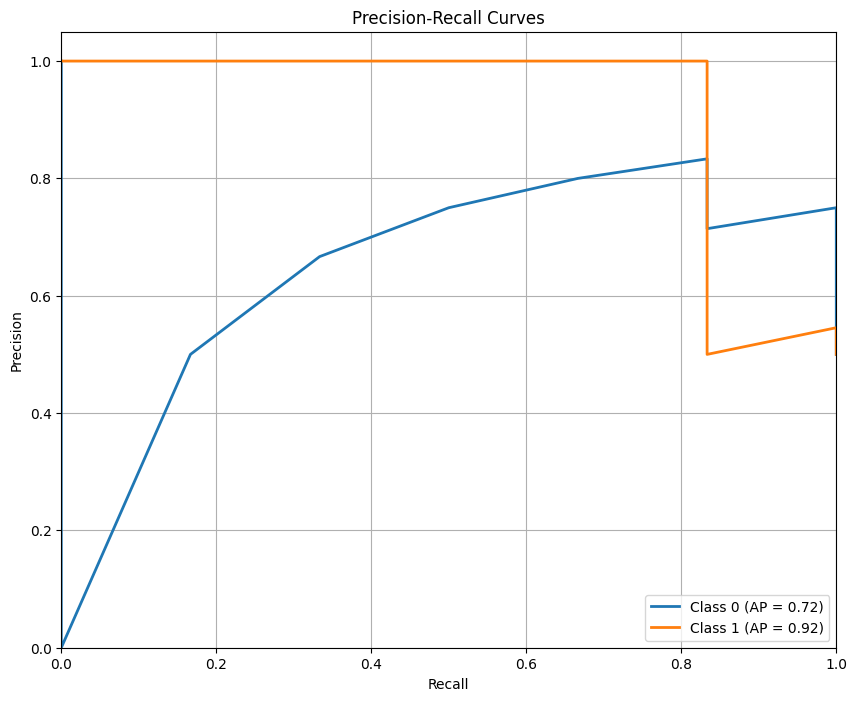

In [51]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [52]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_rnn_model(hp):
    input_size = x_train_rnn.shape[1]
    output_size = y_train.shape[1]

    model = models.Sequential()

    model.add(layers.SimpleRNN(
        units=hp.Choice('rnn_units_1', values=[32, 64]),
        activation='tanh',
        return_sequences=True,
        input_shape=(input_size, 1),
        kernel_regularizer=regularizers.l2(0.01)
    ))

    model.add(layers.Dropout(hp.Choice('dropout_1', values=[0.3, 0.4])))

    model.add(layers.SimpleRNN(
        units=hp.Choice('rnn_units_2', values=[16, 32]),
        activation='tanh',
        return_sequences=False,
        kernel_regularizer=regularizers.l2(0.01)
    ))

    model.add(layers.Dense(
        units=hp.Choice('dense_units_1', values=[32, 64]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.02)
    ))
    model.add(layers.Dropout(hp.Choice('dropout_2', values=[0.3, 0.4])))

    model.add(layers.Dense(output_size, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_rnn_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='RNN_tuning',
    project_name='RNN_Hyperparameter_Tuning'
)

hyper_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    x_train_rnn, y_train,
    validation_data=(x_test_rnn, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"RNN Layer 1 Units: {best_hps.get('rnn_units_1')}")
print(f"RNN Layer 2 Units: {best_hps.get('rnn_units_2')}")
print(f"Dropout in Layer 1: {best_hps.get('dropout_1')}")
print(f"Dropout in Dense Layer 1: {best_hps.get('dropout_2')}")
print(f"Dense Layer 1 Units: {best_hps.get('dense_units_1')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_rnn, y_train,
    validation_data=(x_test_rnn, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

val_loss, val_accuracy = best_model.evaluate(x_test_rnn, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred_best = best_model.predict(x_test_rnn)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)
y_true_best_classes = np.argmax(y_test, axis=1)

Reloading Tuner from RNN_tuning\RNN_Hyperparameter_Tuning\tuner0.json
Best Hyperparameters:
RNN Layer 1 Units: 32
RNN Layer 2 Units: 32
Dropout in Layer 1: 0.3
Dropout in Dense Layer 1: 0.3
Dense Layer 1 Units: 32
Learning Rate: 0.005
Epoch 1/150


c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.3899 - loss: 1.7634 - val_accuracy: 0.6667 - val_loss: 1.6164
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5788 - loss: 1.6063 - val_accuracy: 0.6667 - val_loss: 1.5422
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5539 - loss: 1.5208 - val_accuracy: 0.7500 - val_loss: 1.4864
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6639 - loss: 1.4564 - val_accuracy: 0.7500 - val_loss: 1.4336
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5684 - loss: 1.4224 - val_accuracy: 0.6667 - val_loss: 1.3786
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6182 - loss: 1.3445 - val_accuracy: 0.6667 - val_loss: 1.3290
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5788 - loss: 1.2817 - val_accuracy: 0.7500 - val_loss: 1.2796
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6929 - loss: 1.2319 - val_accuracy: 0.7500 - val_loss: 1.2321
Epo

In [67]:
print("Classification Report:")
print(classification_report(y_true_best_classes, y_pred_best_classes))

accuracy = accuracy_score(y_true_best_classes, y_pred_best_classes)
roc_auc = roc_auc_score(y_test, y_pred_best, multi_class='ovr', average='weighted')
precision = precision_score(y_true_best_classes, y_pred_best_classes, average='macro')
recall = recall_score(y_true_best_classes, y_pred_best_classes, average='macro')
f1 = f1_score(y_true_best_classes, y_pred_best_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.62      0.83      0.71         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12

Accuracy: 0.67
ROC-AUC Score: 0.72
Precision: 0.69
Recall: 0.67
F1-Score: 0.66


<Figure size 1000x800 with 0 Axes>

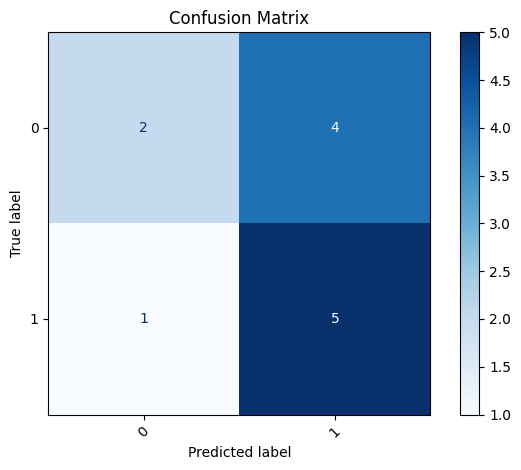

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_best_classes, y_pred_best_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

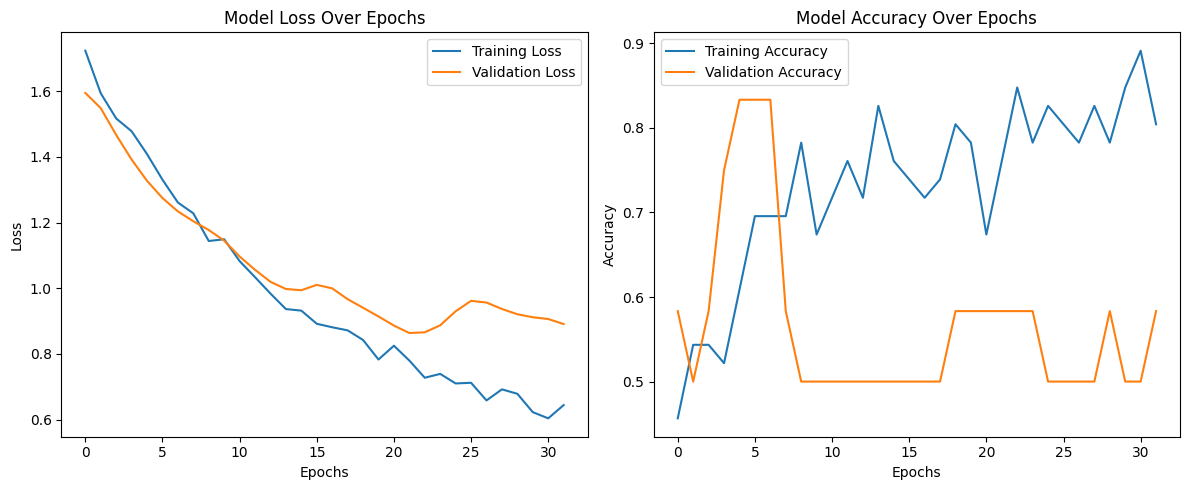

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

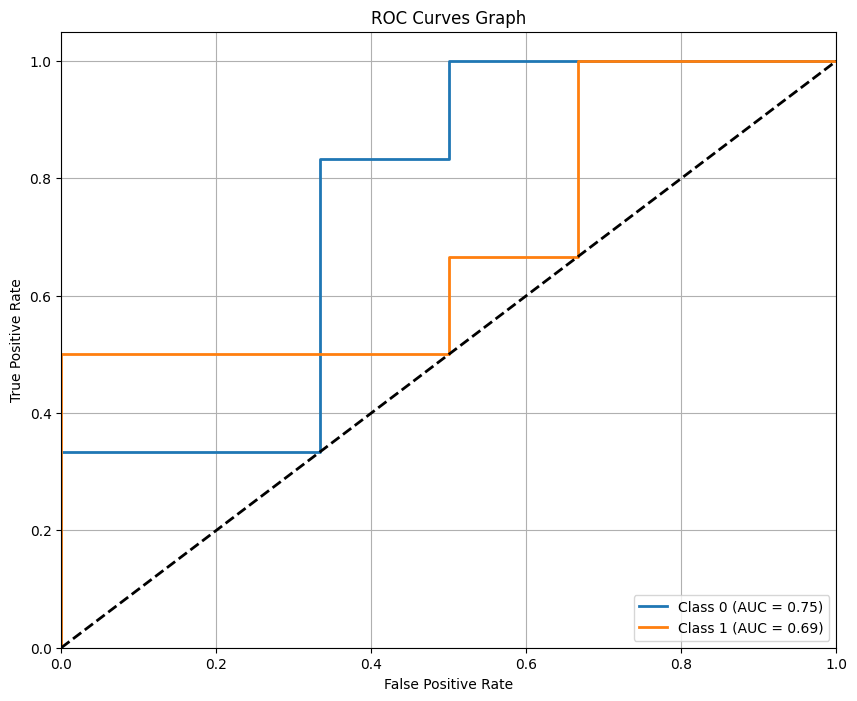

In [57]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

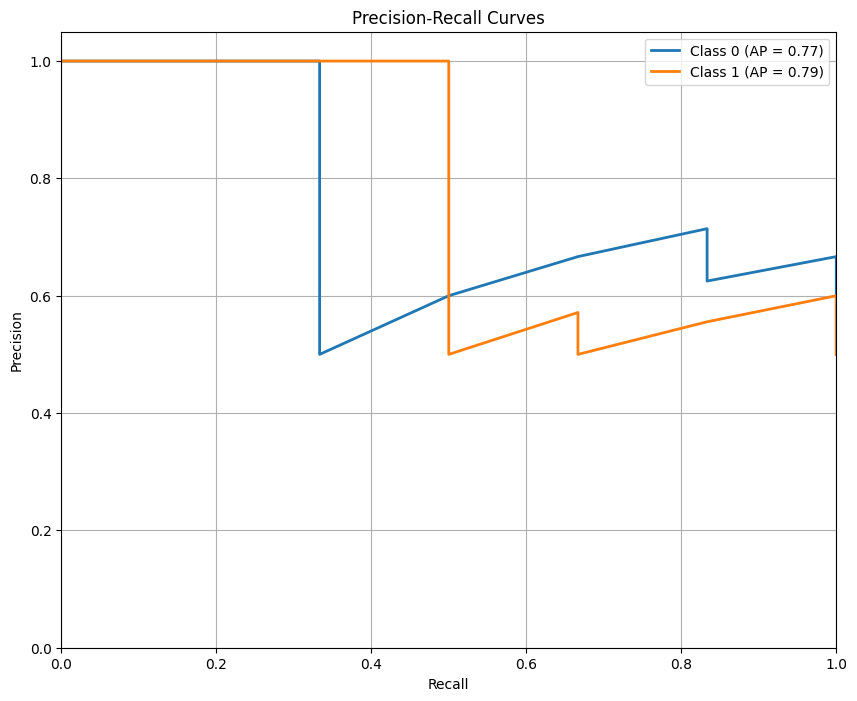

In [58]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_best[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_best[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 13, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,712 (112.16 KB)

 Trainable params: 9,570 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,142 (74.78 KB)

In [60]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 13, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,872 (50.29 KB)

 Trainable params: 4,290 (16.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,582 (33.53 KB)

In [ ]:
import shap

subset_data = x_test_rnn
subset_data_reshaped = subset_data.reshape(subset_data.shape[0], subset_data.shape[1])

explainer = shap.KernelExplainer(model, subset_data_reshaped)

shap_values = explainer.shap_values(subset_data_reshaped)

  0%|          | 0/12 [00:00<?, ?it/s]

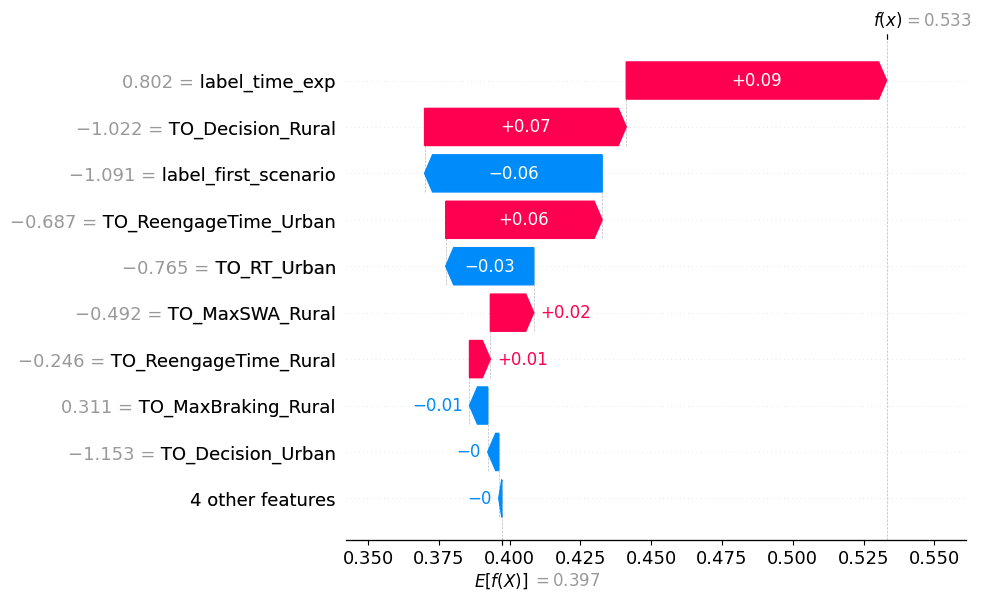

In [ ]:
# Feature names
feature_names = data.drop(columns=['subject_id', 'label_sleep']).columns.tolist()
expected_value = explainer.expected_value[0]

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0, :, 0],
        base_values=expected_value,
        data=subset_data[0].flatten(),
        feature_names=feature_names
    ),
)

In [ ]:
shap.initjs()
subset_data_reshaped = subset_data.reshape(subset_data.shape[0], subset_data.shape[1])

shap.plots.force(
    expected_value,
    shap_values[:, :, 0],
    subset_data_reshaped,
    feature_names=feature_names
)

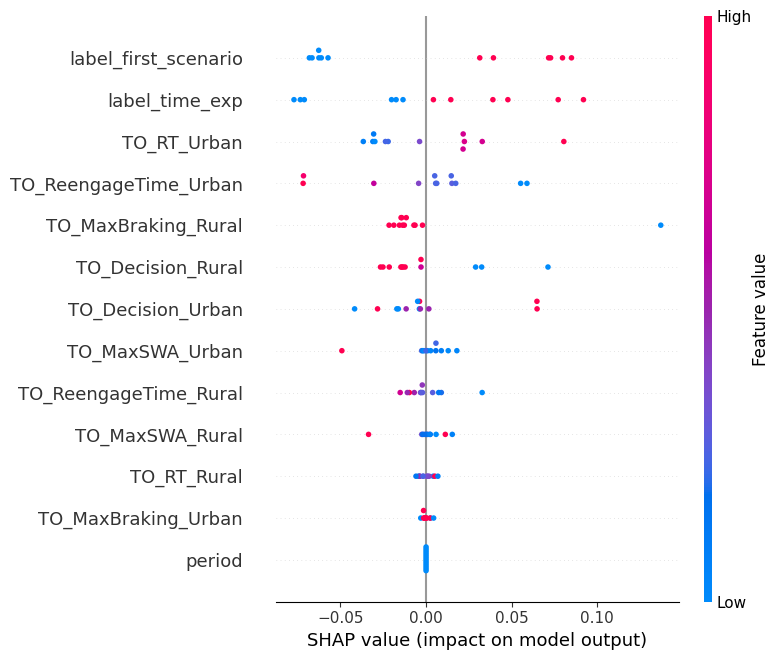

In [ ]:
shap.summary_plot(
    shap_values[:, :, 0],
    subset_data_reshaped,
    feature_names=feature_names
)

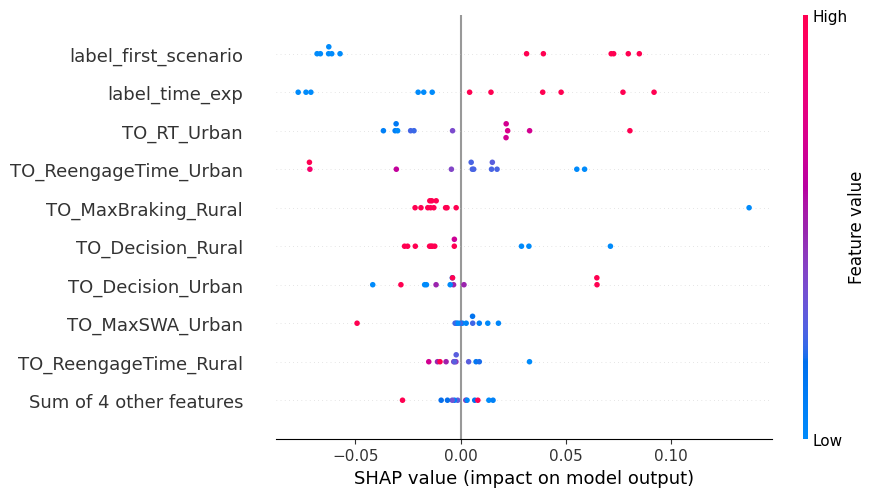

In [ ]:
shap_exp = shap.Explanation(
    values=shap_values[:, :, 0],
    base_values=expected_value,
    data=subset_data_reshaped,
    feature_names=feature_names
)

shap.plots.beeswarm(shap_exp)